## Learning objectives
- Conceptually understand maximum likelihood as applied to logistic regression
- Can run and interpret parameters of logistic regression using statsmodels.
- Can calculate True Positive Rate and False Positive Rate and understand relationship with Area Under ROC curve

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

sns.set_theme() 
sites = pd.read_table("../data/eco_data/eco_sites.txt")
counts = pd.read_table("../data/eco_data/species_counts.txt")


is_mega = counts.columns.str.contains('Megalaima')
sites['has_mega'] = counts.loc[:,is_mega].sum(axis=1) > 0
sites.head()

,Elevation,North,East,WorE,has_mega
A2,198.25,26.978983,92.921975,E,True
A3,734.25,27.006267,92.404575,E,True
A4,1243.25,27.027496,92.410408,E,True
A6,2629.00,27.147733,92.459379,E,False
A7,2340.25,27.091979,92.408567,E,False


## Daily Homework
1) Write linear model to model presence of bird species as a function of elevation. Explain how you picked your parameters of your model
2) Using the elevations in the real data, plot elevation versus probability of seeing the bird species, using the parameters of your model to estimte the probabilities

Text(0, 0.5, 'log odds in bin')

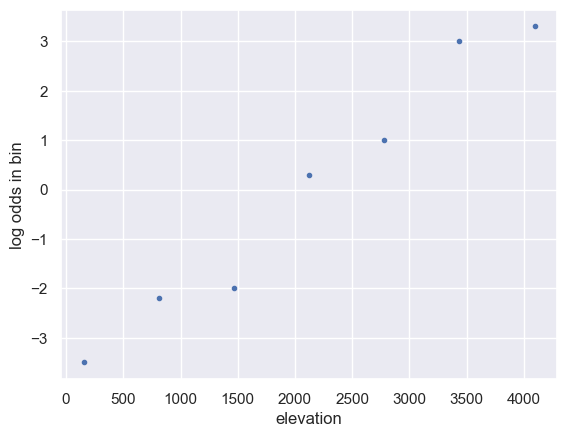

In [5]:
elevation_bins = np.linspace(sites['Elevation'].min(), sites['Elevation'].max(), 7)
fake = [-3.5, -2.2, -2, .3,1,3,3.3]
plt.plot(elevation_bins, fake,'.')
plt.xlabel("elevation")
plt.ylabel("log odds in bin")

## 1. Maximum likelihood for logistic regression
With linear regression we calculated the likelihood of the linear model with the following steps:

1. Use the linear mode lobtain the predicted mean for each observation (`loc`) 
2. Use this `loc` with a `scale` to create a normal model and use that model to see the probability (likelihood) of your observations
3. repeat this for all observations --> log the likelihoods --> add them up
4. the best model has the highest likelihood

You can do the same thing for our binary/logistic regression. The differences are:
1. Your linear model is predicting log odds
2. Then you need to convert log odds to `p` of a Bernoulli model to get the likelihooe of each observation.

**Exercise 1.1**: Calculate the likelihood of our observations given 1) the slope you estimated and 2) using the linear model from the homework. *Write out the algorithm first* 

## 2 Using statsmodels
Just like we did with linear regression, we can fit the best model in the binary case using modeling packages that use maximum likelihood to find the best numbers.

We do the same procedure of making the input data frame, and adding the intercept:

In [3]:
import statsmodels.api as sm

to_model = sites.loc[:,['has_mega','Elevation']]
to_model = sm.add_constant(to_model)
to_model.head()

,const,has_mega,Elevation
A2,1.0,True,198.25
A3,1.0,True,734.25
A4,1.0,True,1243.25
A6,1.0,False,2629.00
A7,1.0,False,2340.25


Then, everything else is the same too but we use `Logit` instead of `OLS`:

In [7]:
y = to_model['has_mega']
X = to_model.drop(['has_mega'],axis=1)
lr_mod = sm.Logit(y, X).fit()
lr_mod.summary()

Optimization terminated successfully.
         Current function value: 0.329815
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               has_mega   No. Observations:                   38
Model:                          Logit   Df Residuals:                       36
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Dec 2022   Pseudo R-squ.:                  0.5203
Time:                        13:48:05   Log-Likelihood:                -12.533
converged:                       True   LL-Null:                       -26.129
Covariance Type:            nonrobust   LLR p-value:                 1.843e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6293      1.200      3.025      0.002       1.278       5.981
Elevation     -0.0021      0.001     -3.376      0.001      -0.003      -0.001
==============================================================================
"""

**Exercise 2.1**: Discuss: the model coefficients (parameters) are again given in the `coef` column. Compare them to your estimates. What is their meaning in terms of human language? Fill it in below.
- meaning of `const` parameter:
- meaning of `Elevation` parameter:

**Exercise 2.2**: Without using the `predict` function, predict the log-odds of megalaima at elevation = 1500 and at elevation = 1501.  What is the difference in the log-odds?

In [ ]:
lr_mod.predict(X)

**Exercise 2.3**: You can re-use your code from Notebook 21 Exercise 4.2 (or not), copy it below but use the parameters of the model above to predict the log odds and the p, and to plot the elevations against the p. Compare it to the histogram of the actual data (again copied below). How do the two plots relate to each other?

In [ ]:
predicted_odds = ## fill this in
plt.plot(sites['Elevation'], predicted_odds,'.')

In [ ]:
sns.displot(data=sites, x="Elevation", hue="has_mega", kde=True)

**Exercise 2.4**: The absolute value of the effect of elevation on megalaima is small (only -0.002). That's because elevation is in meters, and a 1 meter change in elevation is not going to have a big effect. Divide elevation by 100 to get the elevation in *hundreds of meters*, and save that to a new column in the `sites` data frame called `elevation100`. Predict the parameters you will get if you re-run the logistic regression Then, re-run the model but using `elevation100` instead of elevation as the predictor, and compare the results you get versus the first logistic regression. Explain what it means.

In [8]:
sites['elevation100'] = sites['Elevation'] / 100
# Should get same const (3.6) and a slope that is multiplied by 100 (-0.21)
to_model = sites.loc[:,['has_mega','Elevation']]
to_model = sm.add_constant(to_model)

## 3 Evaluating logistic regression model

In [ ]:
pred

Because we are modeling a binary feature, RMSE and R-squared don't work so well. We usually use approaches that measure how well we are able to **classify** 0s and 1s. We can make a number of classifiers from our predictions. Let's say we pick a particular cutoff like 0.7 and we say all predictions of p > 0.7, we predict those are 1's and everything else is 0's. So everything with p > 0.7 is a *positive* and everything else is a *negative*. 

Definitions:
- **positive**: what we predict to be 1
- **negative**: what we predict to be 0
- **true positive (TP)**: we predict a 1 and it *is* a 1
- **false positive (FP)**: we predict a 1 and it *is* a 0

How good is this at predicting 0 vs 1? There are a number of ways to measure this but two key ones are:
- what fraction of 1's test positive? This is called the **true positive rate** 
$$ TruePositiveRate= {TruePositive \over{total 1s}}$$
- what fraction of 0's test positive? This is called the **false positive rate**
$$ FalsePositiveRate= {FalsePositive \over{total 0s}}$$

We can calculate these 
So obviously we want to have a high True Positive Rate while also having a low  False Positive Rate.

**Exercise 3.1**: Which do you expect to have a higher true positive rate, a cutoff of 0.1 or a cutoff of 0.9? And which do you expect to have a higher false positive rate? Explain.

In [10]:
# 0.9 has a higher TPR
# 0.1 has a higher FPR

**Exercise 3.2**: Create 100 cutoffs for predicting positive vs negative. For each one, calculate True Positive Rate and False Positive Rate by filling in the code. You need to use vectorized operations. Store the TPR and FPR for each cutoff in 2 lists called `tpr` and `fpr`. 

In [13]:
to_model = sites.loc[:,['has_mega','Elevation']]
to_model = sm.add_constant(to_model)
to_model.head()
y = to_model['has_mega']
X = to_model.drop(['has_mega'],axis=1)
lr_mod = sm.Logit(y, X).fit()
# builds a logistic model of our data to use for the cutoffs
net = np.linspace(0.01,0.99,100)
tpr = []
fpr = []
# create two lists to store our outputs
pred = lr_mod.predict(X)
# Predict from the logistic model

# Find total0s and total1s (total has_mega and total !has_mega)
total0s = (sites['has_mega'] == 0).astype(int).sum()
total1s = (sites['has_mega'] == 1).astype(int).sum()

# For each cutoff
for cutoff in net:
    # Add the cutoff to the df
    sites['has_mega_preds'] = (pred > cutoff).astype(int)

    # Find the number of true positives (real is 1, pred is 1) 
    true_positives = ((sites['has_mega'] == 1) & (sites['has_mega_preds'] == 1)).astype(int).sum()

    # Find the number of false positives (real is 0, pred is 1)
    false_positives = ((sites['has_mega'] == 0) & (sites['has_mega_preds'] == 1)).astype(int).sum()

    # Calculate/Print the true positive rate (tpr) and false positive rate (fpr)
    tpr.append(true_positives / total1s)
    fpr.append(false_positives / total0s)
    # saves true positive test and false positive test and cutoff into our dictionary

Optimization terminated successfully.
         Current function value: 0.329815
         Iterations 7


Then we can plot these against each other to visualize the result. This is called the **ROC curve**. 

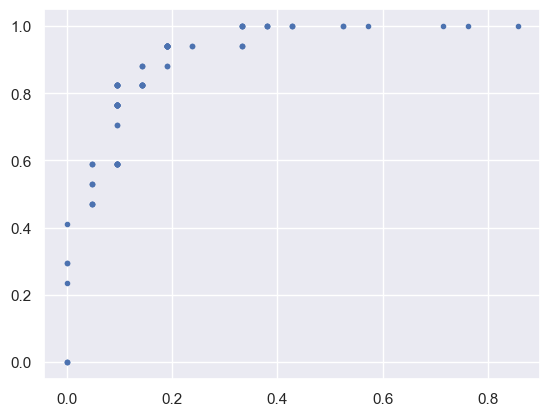

In [14]:
plt.plot(fpr, tpr, '.')

We can randomly re-order the predictions so they have nothing to do with the actual sites using `np.random.permutation`. Try it below with just 4 numbers so you can see what it does:

In [ ]:
np.random.permutation([1,2,3,4])

**Exercise 3.3**: Use the `np.random.permutation` to reorder your predictions so every site gets a random prediction. Then copy your code from 3.2 and create a plot to show the ROC curve for these random predictions

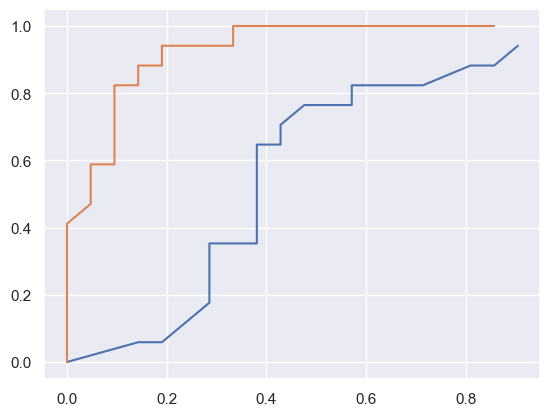

In [15]:
# Create a permutation of the predictions
permuted_prediction = np.random.permutation(pred)
tpr2 = []
fpr2 = []

# Find total0s and total1s (total has_mega and total !has_mega)
total0s = (sites['has_mega'] == 0).astype(int).sum()
total1s = (sites['has_mega'] == 1).astype(int).sum()

# For each cutoff
for cutoff in net:
    # Add the cutoff to the df
    sites['has_mega_preds2'] = (permuted_prediction > cutoff).astype(int)

    # Find the number of true positives (real is 1, pred is 1) 
    true_positives = ((sites['has_mega'] == 1) & (sites['has_mega_preds2'] == 1)).astype(int).sum()

    # Find the number of false positives (real is 0, pred is 1)
    false_positives = ((sites['has_mega'] == 0) & (sites['has_mega_preds2'] == 1)).astype(int).sum()

    # Calculate/Print the true positive rate (tpr) and false positive rate (fpr)
    tpr2.append(true_positives / total1s)
    fpr2.append(false_positives / total0s)
    # saves true positive test and false positive test and cutoff into our dictionary

plt.plot(fpr2, tpr2)
plt.plot(fpr, tpr)

We can quantify this by getting the **area under the ROC curve**. 

To calculate it, we can use the roc_auc_score function, giving it the true 0's and 1's and our predictions:

In [16]:
from sklearn.metrics import roc_auc_score

In [17]:
roc_auc_score(y, pred)

0.9327731092436975

In [18]:
roc_auc_score(y, permuted_prediction)

0.5658263305322129


**Exercise 3.4**: What is the maximum area under the curve? What is the minimum? Draw what a good model's ROC curve would look like. Describe what kind of number you expect for the AUC.

